# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [70]:
#Import all libraries needed at first for cleaner and clearer code
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from copy import deepcopy
import random
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif, f_classif
from sklearn.feature_selection import VarianceThreshold, RFECV, RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict, cross_val_score, cross_validate, GroupShuffleSplit, KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, plot_roc_curve, plot_precision_recall_curve,mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.patches as patches

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

In [3]:
from scipy import stats
import numpy as np
#Check if there are outliers
z = np.abs(stats.zscore(X))
threshold = 3
print(len(np.where(z > 3)) > 0)

True


In [4]:
#Normalize feature data
#TODO: MinMaxScaler
scaler = RobustScaler()
X = scaler.fit_transform(X)
X.shape

(180, 432)

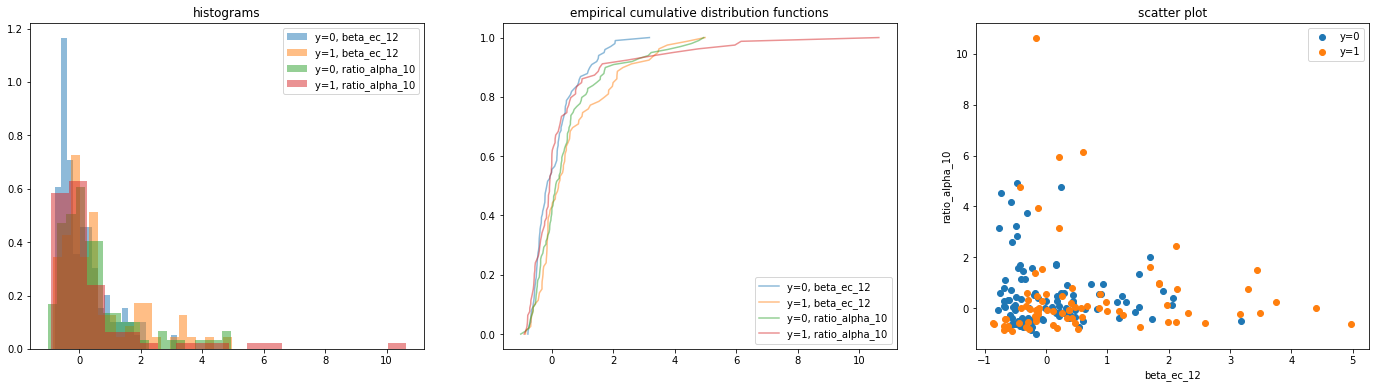

In [5]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

<b>Step 1:</b><br>
Data Analysis and exploration

In [6]:
# Extract data as dataframe to explore later on
features = pd.DataFrame(data=X, columns=feature_names)

In [7]:
#Check for NaN values:
features.isnull().values.any()

False

Combine features based on waves:

In [8]:
#Alpha, beta and theta waves for eyes open
alpha_eo = features.iloc[:,0:48]
beta_eo = features.iloc[:,48:48*2]
theta_eo = features.iloc[:,48*2:48*3]
#Alpha, beta and theta waves for eyes closed
alpha_ec = features.iloc[:,48*3:48*4]
beta_ec = features.iloc[:,48*4:48*5]
theta_ec = features.iloc[:,48*5:48*6]
#Ratio for alpha beta and theta eyes open/ eyes closed
alpha_r = features.iloc[:,48*6:48*7]
beta_r = features.iloc[:,48*7:48*8]
theta_r = features.iloc[:,48*8:48*9]
#Add all features in a list for ease of manipulation
independent_variables = [alpha_eo,alpha_ec,alpha_r,beta_eo,beta_ec,beta_r,theta_eo,theta_ec,theta_r]

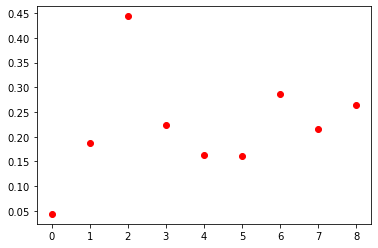

In [9]:
#Get the means of each feature and plot them
means = []
for feature in independent_variables:
    means.append(np.mean(feature.values))
plt.scatter(range(0,len(independent_variables)),means,c="r")

In [10]:
#Calculate correlation matrix to check the values of between 0 and 1 of all features, it would be a good idea
#to eliminate features that are highly correlated
corr_matrix = features.corr(method = "spearman").abs()

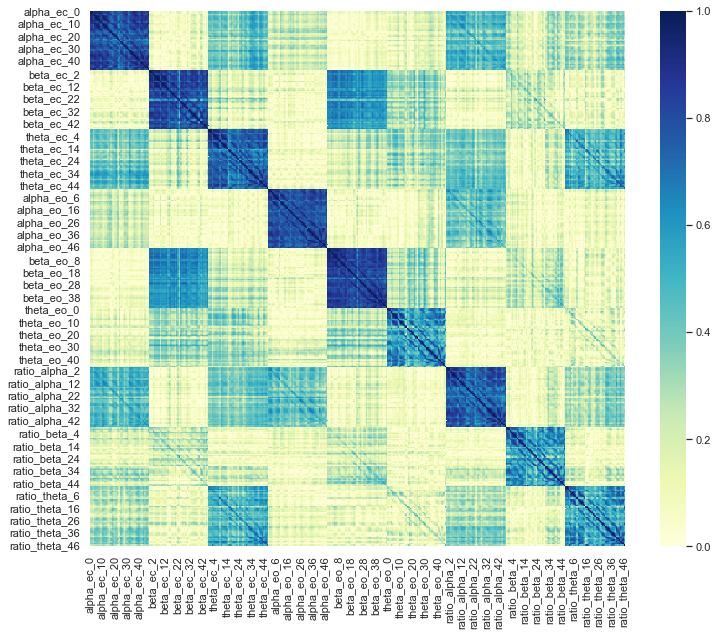

In [11]:
# Draw the heatmap on some examples
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()

In [12]:
alpha_waves = independent_variables[0].join(independent_variables[1]).join(
    independent_variables[2]).join(
    pd.DataFrame(y,columns=["labels"]))

beta_waves = independent_variables[3].join(independent_variables[4]).join(
    independent_variables[5]).join(
    pd.DataFrame(y,columns=["labels"]))

theta_waves = independent_variables[6].join(independent_variables[7]).join(
    independent_variables[8]).join(
    pd.DataFrame(y,columns=["labels"]))

<b>ALPHA WAVES</b>

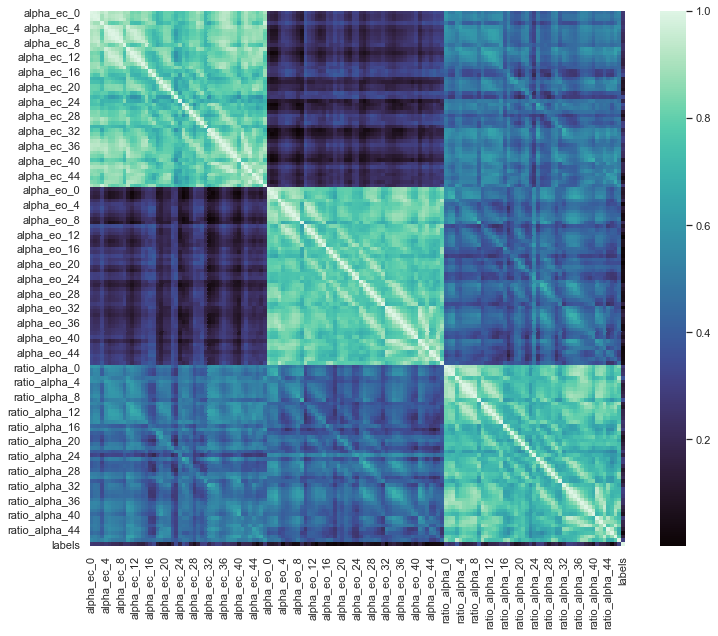

In [13]:
alpha_corr = alpha_waves.corr(method="spearman").abs()
# Draw the heatmap on alpha waves
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(alpha_corr, square=True, ax = ax, cmap="mako")
f.tight_layout()

<b>BETA WAVES CORRELATION</b>

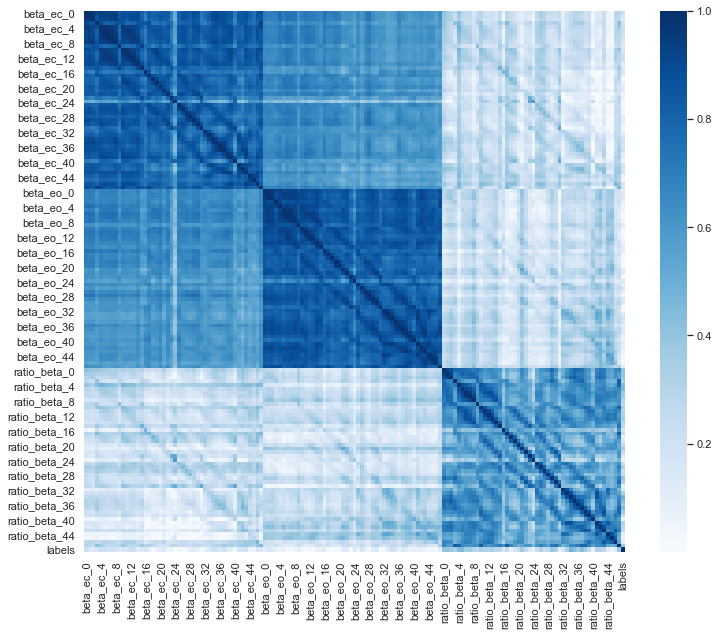

In [14]:
beta_corr = beta_waves.corr(method="spearman").abs()
# Draw the heatmap on beta waves
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(beta_corr, square=True, ax = ax, cmap="Blues")
f.tight_layout()

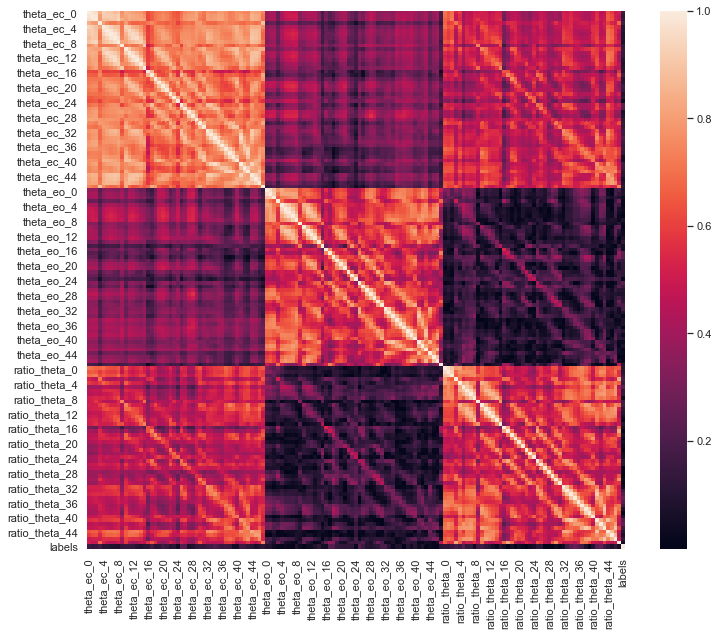

In [15]:
theta_corr = theta_waves.corr(method="spearman").abs()
# Draw the heatmap on theta waves
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(theta_corr, square=True, ax = ax)
f.tight_layout()

From the correlation maps above, we can see that some features within the waves are highly correlated together, hence working as some kind of duplication of information.

<b>Step 2:</b> Feature engineering + Result Testing<br>
In this step, we will test some feature engineering methods to reduce feature dimensions in order to achieve higher performance.

In [16]:
#Since the experiments needs one subject out, we will group every 9 rows as a subject

groups = np.zeros(180).astype(int)

counter = 0
subject = 0

while(counter < 180):
    if(counter%10==0 and counter !=0):
        subject+=1
    groups[counter] = subject
    counter+=1

In [17]:
#This dataframe will hold the different results from the different methods used
results_final = pd.DataFrame()

In [18]:
#This method will be used for ease of extracting the different metrics from the confusion matrix
def get_scores(cm, y_preds):
    
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]

    sp = TN/(TN + FP)
    se = TP/(TP + FN)
    pr = TP/(TP+FP)
    f1 = 2*pr*se/(pr+se)
    f, t, th = roc_curve(y, y_preds)

    auc_score = auc(f,t)
    
    return [0,0,sp, se, pr, f1, auc_score]

In [19]:
score_names = ['Accuracy Mean','Accuracy Std','Specificity','Sensitivity','Precision', 'F1 Score','AUC Score', 'Execution Time (s)','Number of Features']

<b>Part 0:</b> Baseline

In [20]:
y[y == 0] = -1 #Perform for SVM output of {-1,1}

In [21]:
#Set seed for random number generator
random.seed(42)

In [22]:
#Prepare array to save roc curves of different methods
roc_curves = []

In [23]:
# Set Grid search parameters for SVC
grid_params = {'C': [0.001,0.003,0.004,0.005,0.006,0.007,0.008,0.009, 0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1]}

In [24]:
#Group split used for cross validation:
LOGO = LeaveOneGroupOut()

In [99]:
#Prepare general method for predicting y labels excluding baseline:

def predict(X, y, cv, groups, model = None):
    
    print(f"{X.shape[1]} Features")
    
    if(not model):
        
        cv_b = LOGO.split(X,y,groups)

        #Create the GridSearchCV object

        grid_clf = GridSearchCV(SVC(kernel = "linear"), grid_params,cv=cv_b)

        grid_clf.fit(X, y)

        model_params = grid_clf.best_params_

        #Print the best parameters

        print(f"Best Parameters: {model_params}")
    
        model = SVC(kernel="linear",C=model_params['C'], gamma=model_params['gamma'], probability=True)
        
    trains = []
    tests = []
    
    y_tests = []
    y_predictions = []
    for train_idx, test_idx in LOGO.split(X,y,groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_p_train = model.predict(X_train)
        train_acc = model.score(X_train, y_train)
        y_p_test = model.predict(X_test)
        y_predictions.append(y_p_test)
        y_tests.append(y_test)
        test_acc = model.score(X_test, y_test)
        trains.append(train_acc)
        tests.append(test_acc)
        
    print("Train accuracy: " + str(np.mean((trains))))
    print("Test accuracy: " + str(np.mean(tests)))
    
#     print(confusion_matrix(y_tests,y_predictions))
    print(len(y_tests))
    print(len(y_predictions))

    cv_0 = cv.split(X, y, groups)

    accuracy = cross_val_score(model, X, y, cv=cv_0, n_jobs=-1)

    cv_1 = cv.split(X, y, groups)

    y_preds = cross_val_predict(model, X, y, cv=cv_1, n_jobs=-1)

    cv_2 = cv.split(X, y, groups)

    y_preds_proba = cross_val_predict(model, X, y, cv = cv_2, method = "predict_proba")

    fpr, tpr, _ = roc_curve(y,y_preds_proba[:,1])

    cm = confusion_matrix(y, y_preds)
    
    return y_preds, cm, fpr, tpr, accuracy, model, trains, tests

In [82]:
#Prepare method for filtering X and reducing dimensions:
def filter(X, y, groups, f_type, cv, model=None):
    
    cv_base = cv.split(X, y, groups)

    N_FEATURES_OPTIONS = range(0,X.shape[1],20)

    anova = SelectKBest(score_func=f_type)
    
    if(not model):

        param = {'reduce_dim': [anova], 
                 'reduce_dim__k': N_FEATURES_OPTIONS,
                 'classify__C': [0.001,0.003,0.004,0.005,0.006,0.007,0.008,0.009, 0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1, 1, 10, 100]}

        pipe = Pipeline(steps=[('reduce_dim','passthrough'), ('classify', SVC(kernel = "linear"))])
    
    else:
        
        param = {'reduce_dim': [anova], 
                 'reduce_dim__k': N_FEATURES_OPTIONS}

        pipe = Pipeline(steps=[('reduce_dim','passthrough'), ('classify', model)])

    grid = GridSearchCV(pipe, n_jobs=-1, param_grid=param, cv=cv_base)

    grid.fit(deepcopy(X),y)

    #After getting the best k number of features based on accuracy score, we will use it and get all metrics.
    best_k = grid.best_params_["reduce_dim__k"]

    filter_best = SelectKBest(score_func=f_type,k=best_k)

    X_reduced = filter_best.fit_transform(deepcopy(X),y)
    
    if(not model):
    
        model_params = grid.best_params_['classify__C']

        print(f"{X_reduced.shape[1]} features")
        
    else:
        
        model_params = None
    
    return X_reduced, model_params

In [101]:
#Baseline Code:
start_time = time.time()

y_preds_base, cm_base, fpr_base, tpr_base, accuracy_base, model_base, trains_base, tests_base = predict(X, y, LOGO, groups)

mean_acc_base = np.mean(accuracy_base)

std_acc_base = np.std(accuracy_base)

plt.figure(figsize = (10,7))

plt.title("Baseline CM")

sns.heatmap(cm_base, annot=True,cmap="Blues")

scores_base = get_scores(cm_base, y_preds_base)

scores_base[0] = mean_acc_base

scores_base[1] = std_acc_base

execution_time = time.time() - start_time

432 Features
Best Parameters: {'C': 0.007, 'gamma': 0.0001}
Train accuracy: 0.9640522875816993
Test accuracy: 0.9166666666666666
18
18
0.9166666666666666


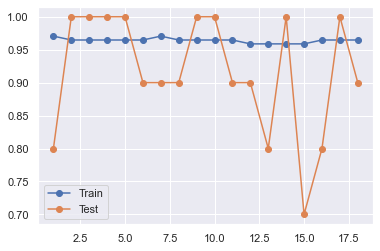

In [89]:
values = [i for i in range(1, 19)]
plt.plot(values, trains_base, '-o', label='Train')
plt.plot(values, tests_base, '-o', label='Test')
plt.legend()
plt.show()

In [28]:
#Add results of baseline to aggregating table
scores_base.append(execution_time)
scores_base.append(int(X.shape[1]))
results_final["Baseline"] = scores_base
results_final.index = score_names

In [29]:
#We can see that the baseline method has room for improvement.
results_final

,Baseline
Accuracy Mean,0.916667
Accuracy Std,0.089753
Specificity,0.933333
Sensitivity,0.904762
Precision,0.950000
F1 Score,0.926829
AUC Score,0.912500
Execution Time (s),9.328073
Number of Features,432.000000


<b>Part 1:</b> Filtering Methods

<b>Method 1:</b> Correlation Filter

In [30]:
#Drop features with correlation > 95%
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
reduced_features = features.drop(to_drop, axis = 1)
reduced_features.shape

(180, 350)

In [31]:
#Remove quasi-constant features with no variance => no information to give
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(reduced_features)

VarianceThreshold(threshold=0.01)

In [32]:
#By the result above, we see that there are 14 quasi constant feature ! which will allow us to further reduce the dims
reduced_features = qconstant_filter.transform(reduced_features)
#New reduced dimensions of features:
print(f"{reduced_features.shape[1]} features")

350 features


In [33]:
reduced_features_df = pd.DataFrame(data=reduced_features)

In [34]:
reduced_features_T = reduced_features.T
reduced_features_T = pd.DataFrame(data=reduced_features_T)

In [35]:
print(reduced_features_T.duplicated().sum())

0


In [36]:
#No duplicates were found. Good !
X_corr = reduced_features
print(f"{X_corr.shape[1]} features")

350 features


350 Features
Best Parameters: {'C': 0.008, 'gamma': 0.0001}
Train accuracy: 0.9522875816993464
Test accuracy: 0.911111111111111


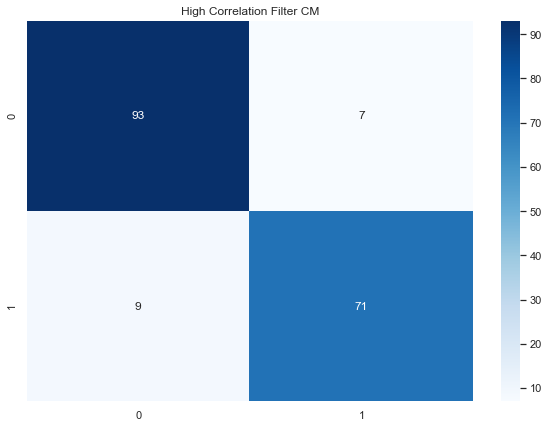

In [37]:
start_time = time.time()

y_preds_corr, cm_corr, fpr_corr, tpr_corr, accuracy_corr, _ = predict(X_corr, y, LOGO, groups)

mean_acc_corr = np.mean(accuracy_corr)

std_acc_corr = np.std(accuracy_corr)

plt.figure(figsize = (10,7))

plt.title("High Correlation Filter CM")

sns.heatmap(cm_corr, annot=True,cmap="Blues")

scores_corr = get_scores(cm_corr, y_preds_corr)

scores_corr[0] = mean_acc_corr

scores_corr[1] = std_acc_corr

execution_time = time.time() - start_time

In [38]:
#Add results to aggregating table
scores_corr.append(execution_time)
scores_corr.append(X_corr.shape[1])
results_final["High Correlation Filter"] = scores_corr

In [39]:
#We can see that this filter degrades the performance. So we will count it out.
results_final

,Baseline,High Correlation Filter
Accuracy Mean,0.916667,0.911111
Accuracy Std,0.089753,0.099381
Specificity,0.933333,0.910256
Sensitivity,0.904762,0.911765
Precision,0.950000,0.930000
F1 Score,0.926829,0.920792
AUC Score,0.912500,0.908750
Execution Time (s),9.328073,7.942854
Number of Features,432.000000,350.000000


<b>Method 2:</b> Mutual Information Filter

In [40]:
#After applying the high correlation filter, we will use the Mutual Information to select the k best features
#We will use GridSearch to find the best k to use

start_time = time.time()

X_mutual, C_mutual = filter(X, y, groups, mutual_info_classif, LOGO, model_base)

execution_time = time.time() - start_time

360 Features
Best Parameters: {'C': 0.03, 'gamma': 0.0001}
Train accuracy: 0.9947712418300654
Test accuracy: 0.9277777777777779


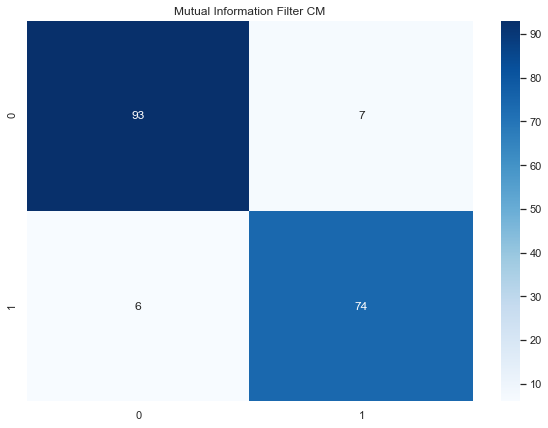

In [47]:
#Test the mutual info method

model_mutual = deepcopy(model_base)

y_preds_mi, cm_mi, fpr_mi, tpr_mi, accuracy_mi, _ = predict(X_mutual, y, LOGO, groups)

mean_acc_mi = np.mean(accuracy_mi)

std_acc_mi = np.std(accuracy_mi)

plt.figure(figsize = (10,7))
    
plt.title("Mutual Information Filter CM")

sns.heatmap(cm_mi, annot=True,cmap="Blues")

scores_mutual = get_scores(cm_mi, y_preds_mi)

scores_mutual[0] = mean_acc_mi

scores_mutual[1] = std_acc_mi

In [48]:
#Add results to aggregating table
scores_mutual.append(execution_time)
scores_mutual.append(X_mutual.shape[1])
results_final["Mutual Information Filter"] = scores_mutual

In [49]:
results_final

,Baseline,High Correlation Filter,Mutual Information Filter
Accuracy Mean,0.916667,0.911111,0.927778
Accuracy Std,0.089753,0.099381,0.065026
Specificity,0.933333,0.910256,0.913580
Sensitivity,0.904762,0.911765,0.939394
Precision,0.950000,0.930000,0.930000
F1 Score,0.926829,0.920792,0.934673
AUC Score,0.912500,0.908750,0.927500
Execution Time (s),9.328073,7.942854,226.806726
Number of Features,432.000000,350.000000,360.000000


<b>Method 3:</b> ANOVA Filter (f-Test)

In [50]:
#After applying the high correlation filter, we will use the ANOVA (f-Test) to select the k best features
#We will use GridSearch to find the best k to use

start_time = time.time()

X_anova, C_anova = filter(X, y, groups, f_classif, LOGO)

print(f"Best model parameters: {C_anova}")

execution_time = time.time() - start_time

300 features
Best model parameters: 0.07


300 Features
Train accuracy: 0.9983660130718953
Test accuracy: 0.9555555555555555


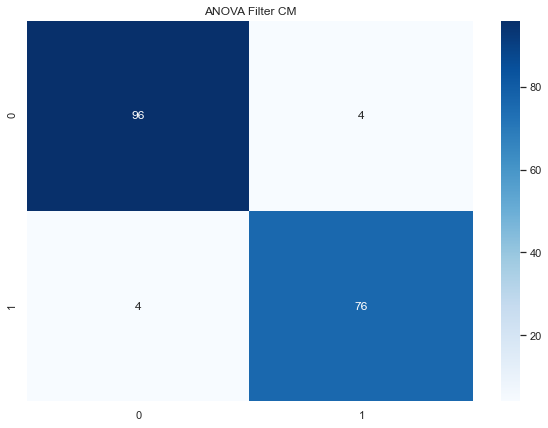

In [54]:
#Test the Anova method

cv_1 = LOGO.split(deepcopy(X_anova), y, groups)

model_anova = SVC(kernel="linear", C = C_anova, probability=True)

y_preds_anova, cm_anova, fpr_anova, tpr_anova, accuracy_anova, _ = predict(X_anova, y, LOGO, groups, model_anova)

mean_acc_anova = np.mean(accuracy_anova)

std_acc_anova = np.std(accuracy_anova)

plt.figure(figsize = (10,7))

plt.title("ANOVA Filter CM")

sns.heatmap(cm_anova, annot=True,cmap="Blues")

scores_anova = get_scores(cm_anova, y_preds_anova)

scores_anova[0] = mean_acc_anova

scores_anova[1] = std_acc_anova

In [55]:
#Add results to aggregating table
scores_anova.append(execution_time)
scores_anova.append(X_anova.shape[1])
results_final["Anova (f-Test) Filter"] = scores_anova

In [56]:
results_final

,Baseline,High Correlation Filter,Mutual Information Filter,Anova (f-Test) Filter
Accuracy Mean,0.916667,0.911111,0.927778,0.955556
Accuracy Std,0.089753,0.099381,0.065026,0.059835
Specificity,0.933333,0.910256,0.913580,0.950000
Sensitivity,0.904762,0.911765,0.939394,0.960000
Precision,0.950000,0.930000,0.930000,0.960000
F1 Score,0.926829,0.920792,0.934673,0.960000
AUC Score,0.912500,0.908750,0.927500,0.955000
Execution Time (s),9.328073,7.942854,226.806726,66.399901
Number of Features,432.000000,350.000000,360.000000,300.000000


<b>Part 2:</b> Wrapper Methods

<b>Method 1</b>: Recursive Elimination with Cross Validation

Optimal number of features : 291


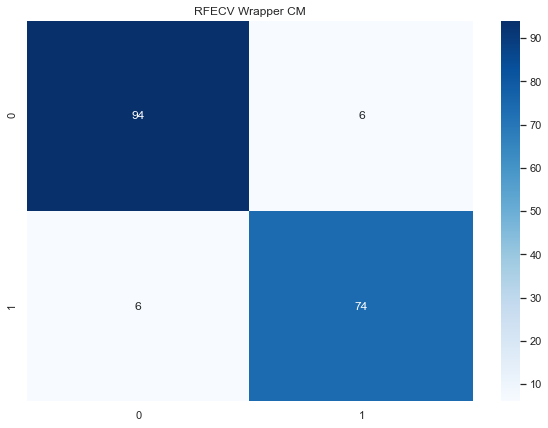

In [57]:
start_time = time.time()

LOGO = LeaveOneGroupOut()

cv_0 = LOGO.split(X, y, groups)

rfecv = RFECV(estimator=model_base, min_features_to_select=1, cv=cv_0,n_jobs=-1)

X_tmp = deepcopy(X)

rfecv.fit(X_tmp, y)

print("Optimal number of features : %d" % rfecv.n_features_)

rfe = RFE(model_base, n_features_to_select=rfecv.n_features_)

X_rfe = rfe.fit_transform(X,y)

cv_grid = LOGO.split(X_rfe, y, groups)

grid_model = GridSearchCV(SVC(kernel="linear"), n_jobs=-1, param_grid=grid_params,cv=cv_grid)

grid_model.fit(X_rfe, y)

model_params_rfe = grid_model.best_params_

cv_1 = LOGO.split(deepcopy(X_rfe), y, groups)

model_rfe = SVC(kernel="linear", C = model_params_rfe['C'], gamma =  model_params_rfe['gamma'], probability=True)

accuracy = cross_val_score(model_rfe, deepcopy(X_rfe), y, cv=cv_1, n_jobs=-1)

mean_acc = np.mean(accuracy)

std_acc = np.std(accuracy)

cv_2 = LOGO.split(deepcopy(X_rfe), y, groups)

y_preds_4 = cross_val_predict(model_rfe, deepcopy(X_rfe), y, cv=cv_2, n_jobs=-1)

cv_3 = LOGO.split(deepcopy(X_rfe), y, groups)

y_preds_4_proba = cross_val_predict(model_rfe, deepcopy(X_rfe), y, cv=cv_3, n_jobs=-1, method="predict_proba")

fpr_4, tpr_4, _ = roc_curve(y,y_preds_4_proba[:,1])

roc_curves.append([fpr_4,tpr_4])

cm_4 = confusion_matrix(y, y_preds_4)

plt.figure(figsize = (10,7))

plt.title("RFECV Wrapper CM")

sns.heatmap(cm_4, annot=True,cmap="Blues")

scores_rfecv = get_scores(cm_4, y_preds_4)

scores_rfecv[0] = mean_acc

scores_rfecv[1] = std_acc

#After that, we can start with our training and testing using different methods for dimensionality reduction.
execution_time = time.time() - start_time

In [60]:
scores_rfecv.append(execution_time)
scores_rfecv.append(rfecv.n_features_)
results_final["RFECV"] = scores_rfecv

ValueError: Length of values (11) does not match length of index (9)

In [61]:
results_final

,Baseline,High Correlation Filter,Mutual Information Filter,Anova (f-Test) Filter,RFECV
Accuracy Mean,0.916667,0.911111,0.927778,0.955556,0.933333
Accuracy Std,0.089753,0.099381,0.065026,0.059835,0.066667
Specificity,0.933333,0.910256,0.913580,0.950000,0.925000
Sensitivity,0.904762,0.911765,0.939394,0.960000,0.940000
Precision,0.950000,0.930000,0.930000,0.960000,0.940000
F1 Score,0.926829,0.920792,0.934673,0.960000,0.940000
AUC Score,0.912500,0.908750,0.927500,0.955000,0.932500
Execution Time (s),9.328073,7.942854,226.806726,66.399901,98.987860
Number of Features,432.000000,350.000000,360.000000,300.000000,291.000000


<b>Part 2:</b> Embedded Methods

<b>Method 1:</b> Ridge Regression

187 Features
Best Parameters: {'C': 0.06, 'gamma': 0.0001}
Train accuracy: 0.9990196078431374
Test accuracy: 0.9722222222222222


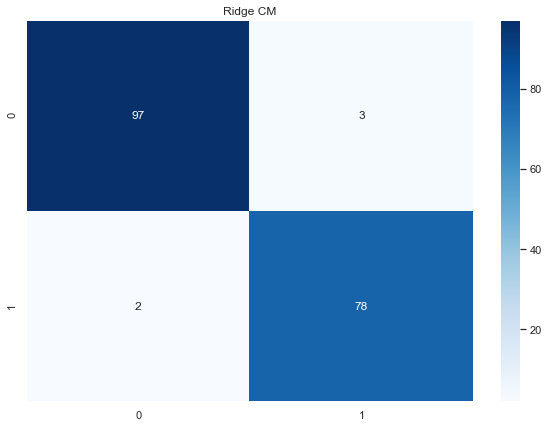

In [62]:
start_time = time.time()

selection = SelectFromModel(LogisticRegression(penalty="l2",random_state=42,C=0.1))

# selection = SelectFromModel(Ridge(alpha=0.05,random_state=42))

selection.fit(X, y)

# see the selected features.
selected_features = features.columns[(selection.get_support())]

cols = []

for f in selected_features:
    cols.append(f)

X_ridge = features[selected_features]

y_preds_ridge, cm_ridge, fpr_ridge, tpr_ridge, accuracy_ridge, _ = predict(X_ridge.values, y, LOGO, groups)

mean_acc_ridge = np.mean(accuracy_ridge)

std_acc_ridge = np.std(accuracy_ridge)

plt.figure(figsize = (10,7))

plt.title("Ridge CM")

sns.heatmap(cm_ridge, annot=True,cmap="Blues")

scores_ridge = get_scores(cm_ridge, y_preds_ridge)

scores_ridge[0] = mean_acc_ridge

scores_ridge[1] = std_acc_ridge

execution_time = time.time() - start_time

NameError: name 'trains' is not defined

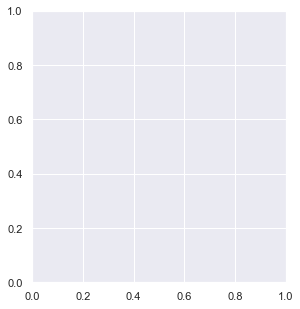

In [63]:
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.plot(range(1, 18 + 1), np.array(trains).ravel(), 'o-')
# plt.xlabel('number of fold')
# plt.ylabel('training acc')
# plt.title('Training acc across folds')
# plt.tight_layout()
# plt.subplot(1,2,2)
# plt.plot(range(1, 18 + 1), np.array(tests).ravel(), 'o-')
# plt.xlabel('number of fold')
# plt.ylabel('testing acc')
# plt.title('Testing acc across folds')
# plt.tight_layout()
# plt.show()

In [64]:
scores_ridge.append(execution_time)
scores_ridge.append(X_ridge.shape[1])
results_final["Ridge"] = scores_ridge

In [65]:
results_final

,Baseline,High Correlation Filter,Mutual Information Filter,Anova (f-Test) Filter,RFECV,Ridge
Accuracy Mean,0.916667,0.911111,0.927778,0.955556,0.933333,0.972222
Accuracy Std,0.089753,0.099381,0.065026,0.059835,0.066667,0.055833
Specificity,0.933333,0.910256,0.913580,0.950000,0.925000,0.962963
Sensitivity,0.904762,0.911765,0.939394,0.960000,0.940000,0.979798
Precision,0.950000,0.930000,0.930000,0.960000,0.940000,0.970000
F1 Score,0.926829,0.920792,0.934673,0.960000,0.940000,0.974874
AUC Score,0.912500,0.908750,0.927500,0.955000,0.932500,0.972500
Execution Time (s),9.328073,7.942854,226.806726,66.399901,98.987860,8.562182
Number of Features,432.000000,350.000000,360.000000,300.000000,291.000000,187.000000


<b>Method 2:</b> Lasso Regression

33 Features
Best Parameters: {'C': 1, 'gamma': 0.0001}
Train accuracy: 0.995751633986928
Test accuracy: 0.9444444444444444


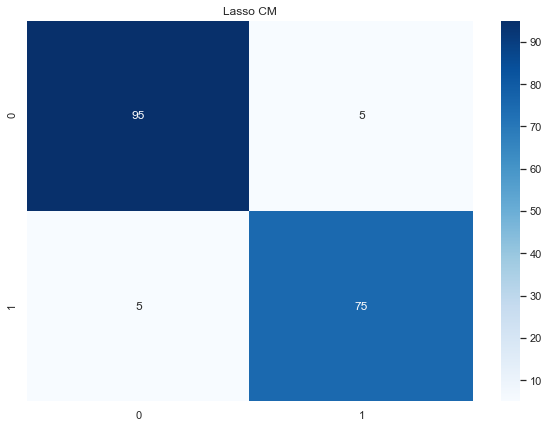

In [66]:
start_time = time.time()

selection = SelectFromModel(Lasso(alpha = 0.05))

selection.fit(X, y)

# see the selected features.
selected_features = features.columns[(selection.get_support())]

cols = []

for f in selected_features:
    cols.append(f)

X_lasso = features[selected_features]

y_preds_lasso, cm_lasso, fpr_lasso, tpr_lasso, accuracy_lasso, _ = predict(X_lasso.values, y, LOGO, groups)

mean_acc_lasso = np.mean(accuracy_lasso)

std_acc_lasso = np.std(accuracy_lasso)

plt.figure(figsize = (10,7))

plt.title("Lasso CM")

sns.heatmap(cm_lasso, annot=True,cmap="Blues")

scores_lasso = get_scores(cm_lasso, y_preds_lasso)

scores_lasso[0] = mean_acc_lasso

scores_lasso[1] = std_acc_lasso

execution_time = time.time() - start_time

NameError: name 'trains' is not defined

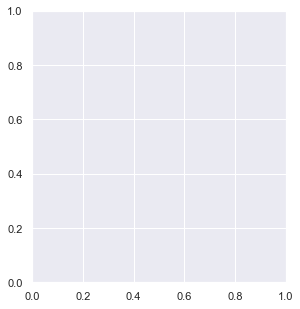

In [67]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, 18 + 1), np.array(trains).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel('training acc')
plt.title('Training acc across folds')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, 18 + 1), np.array(tests).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel('testing acc')
plt.title('Testing acc across folds')
plt.tight_layout()
plt.show()

In [ ]:
scores_lasso.append(execution_time)
scores_lasso.append(X_lasso.shape[1])
results_final["Lasso"] = scores_lasso

In [ ]:
results_final

In [ ]:
# results_final.to_csv('Methods_Scores.csv')  #Uncomment if file does not exist

In [ ]:
idx = 0
legends = ["Baseline","Corr F","Mutual Info F","Anova F","RFECV W","Ridge E"]
auc_scores = results_final.loc["AUC Score",:]
auc_scores = auc_scores[:-1]
roc_curves_plot = roc_curves[:-1]
print(len(roc_curves))
fig = plt.figure(figsize=(20, 20))  # create a figure object
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# patch = patches.Rectangle((1,0.92),10.5,0.01,linewidth=1,linestyle='--',edgecolor='gray',facecolor='none')
# ax.add_patch(patch)
# left, bottom, width, height = [0.3, 0.2, 0.57, 0.3]
# ax2 = fig.add_axes([left, bottom, width, height])
for roc in roc_curves_plot:
    label = legends[idx] + " w/ AUC="+str(auc_scores[idx])
    print(label)
    plt.plot(roc[0],roc[1],marker='.',label = label)
#     ax2.plot(roc[0][15:],roc[1][15:])
    idx+=1
plt.title("Methods ROC curves")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# ax.plot([4.9, 1], [0.89, 0.92], '--', c='gray', lw=1)
# ax.plot([10, 1], [0.89, 0.92], '--', c='gray', lw=1)
plt.show()
plt.savefig('roc_results.png')

In [ ]:
idx = 0
for roc in roc_curves_plot:
    label = legends[idx] + " w/ AUC="+str(auc_scores[idx])
    plt.plot(roc[0][:26],roc[1],marker='.',label = label)
    idx+=1
plt.title("Methods ROC curves")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_results.png')

In [ ]:
auc_scores = results_final.loc["AUC Score",:]
legends = ["B M0","F M1","F M2","F M3","W M1","E M1"]
mean_auc = np.median(auc_scores)
colors = ['b', 'c', 'y', 'm', 'g','k','m']
x = np.linspace(0,5,6)
ax.set_facecolor('w')
m0 = plt.scatter(x[0],auc_scores[0],color = colors[0])
m1 = plt.scatter(x[1],auc_scores[1],color = colors[1])
m2 = plt.scatter(x[2],auc_scores[2],color = colors[2])
m3 = plt.scatter(x[3],auc_scores[3],color = colors[3])
m4 = plt.scatter(x[4],auc_scores[4],color = colors[4])
m5 = plt.scatter(x[3],auc_scores[3],color = colors[6],marker="*")
plt.legend((m0,m1,m2,m3,m4,m5),
           (legends),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)
plt.hlines(mean_auc,min(x),max(x),'r')
plt.savefig('results_graph.png')